In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import scipy.io
from sklearn.preprocessing import LabelEncoder

np.random.seed(42)

In [3]:
# Storing the output
le = LabelEncoder()
data = pd.read_csv('training2017/REFERENCE.csv', header=None, names=['name', 'label'])
y = le.fit_transform(data.label.values)
y = y.reshape(-1, 1)

In [4]:
# Get the number of unique labels
num_labels = len(le.classes_)

# Print the labels encoding
print('Labels encoding:')
for i in range(num_labels):
    print(i, le.inverse_transform([i])[0])

Labels encoding:
0 A
1 N
2 O
3 ~


In [5]:
# Storing the input
def get_data(file):
    data = scipy.io.loadmat(file)['val'][0]
    return data.astype(float)

data_list = [get_data('training2017/{}.mat'.format(i)) for i in data.name.values]

X = np.array(data_list, dtype=object)

In [6]:
sampling_frequency = 300
dt = 1/sampling_frequency
print('The timestep is: ', dt)

The timestep is:  0.0033333333333333335


The ECG were sampled as 300 Hz.
This means every datapoint represent an increment in time of $\frac{1}{300Hz}=0.0033333333333333335s$

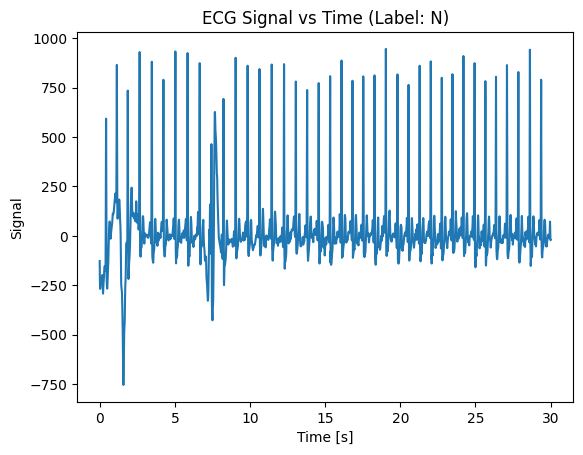

In [7]:
idx = 0

plt.plot(dt*np.arange(len(X[idx])),X[idx])
plt.xlabel('Time [s]')
plt.ylabel('Signal')
plt.title(f'ECG Signal vs Time (Label: {le.inverse_transform(y[idx])[0]})')
plt.show()

# Data Exploration

Labels distribution:
Class: 0 , Count: 738 , Perc :8.7%
Class: 1 , Count: 5050 , Perc :59.2%
Class: 2 , Count: 2456 , Perc :28.8%
Class: 3 , Count: 284 , Perc :3.3%


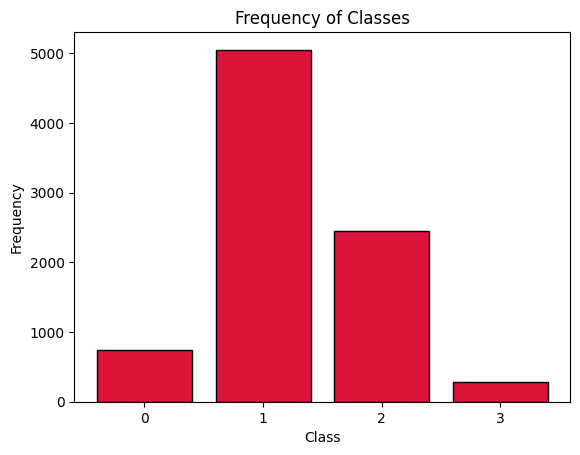

In [8]:
unique_classes, class_counts = np.unique(y, return_counts=True)

print('Labels distribution:')
for i in range(num_labels):
    print('Class:', i, ', Count:', class_counts[i], ', Perc :{:.1f}%'.format(100*class_counts[i]/len(y)))

plt.bar(unique_classes, class_counts, edgecolor='black', color='crimson')
plt.title('Frequency of Classes')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(unique_classes)
plt.show()

In [9]:
print("Shape of X:", X.shape)

Shape of X: (8528,)


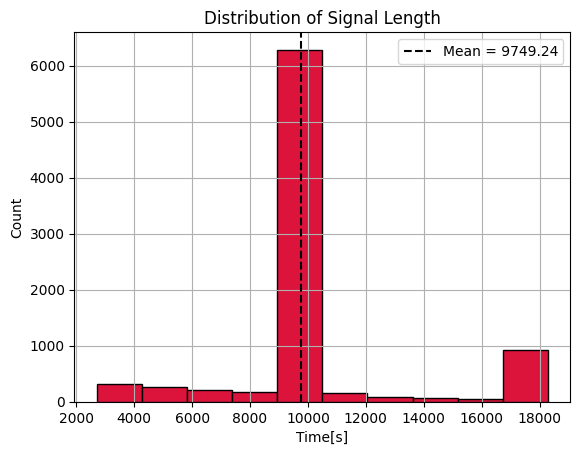

In [10]:
signal_lengths = [len(X[i]) for i in range(0, len(X))]

plt.hist(signal_lengths, edgecolor='black', color='crimson')
plt.axvline(np.mean(signal_lengths), linestyle='--', c='black', label=f'Mean = {np.mean(signal_lengths):.2f}')
plt.title('Distribution of Signal Length')
plt.xlabel('Time[s]')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()

# Preprocessing

In [11]:
def segment_signals(signals, labels, segment_length=9000):
    
    segmented_signals = []
    segmented_labels = []

    for signal, label in zip(signals, labels):
        signal_length = len(signal)
        if signal_length >= segment_length:
            num_segments = signal_length // segment_length
            for i in range(num_segments):
                start_idx = i * segment_length
                end_idx = start_idx + segment_length
                segment = signal[start_idx:end_idx]
                segmented_signals.append(segment)
                segmented_labels.append(label)

    return np.array(segmented_signals), np.array(segmented_labels)
     

segmented_X, segmented_y = segment_signals(X, y)
names_encoding = le.inverse_transform(segmented_y.ravel())
print(segmented_X.shape)
print(segmented_y.shape)

(8409, 9000)
(8409, 1)


In [12]:
label_mapping = {label: le.transform([label])[0] for label in le.classes_}

X_A = segmented_X[segmented_y.ravel() == label_mapping['A']]
y_A = segmented_y[segmented_y.ravel() == label_mapping['A']]

X_N = segmented_X[segmented_y.ravel() == label_mapping['N']]
y_N = segmented_y[segmented_y.ravel() == label_mapping['N']]

X_O = segmented_X[segmented_y.ravel() == label_mapping['O']]
y_O = segmented_y[segmented_y.ravel() == label_mapping['O']]

X_Noise = segmented_X[segmented_y.ravel() == label_mapping['~']]
y_Noise = segmented_y[segmented_y.ravel() == label_mapping['~']]

print(X_A.shape, y_A.shape)
print(X_N.shape, y_N.shape)
print(X_O.shape, y_O.shape)
print(X_Noise.shape, y_Noise.shape)

(718, 9000) (718, 1)
(4937, 9000) (4937, 1)
(2603, 9000) (2603, 1)
(151, 9000) (151, 1)


## Trying to balance the dataset

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(segmented_X, segmented_y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [15]:
# Train split
unique_classes_train, class_counts_train = np.unique(y_train, return_counts=True)
unique_classes_val, class_counts_val = np.unique(y_val, return_counts=True)
unique_classes_test, class_counts_test = np.unique(y_test, return_counts=True)

In [ ]:
print('Labels distribution:')
for i in range(num_labels):
    print('Class:', i, ', Count:', class_counts[i], ', Perc :{:.1f}%'.format(100*class_counts[i]/len(y)))

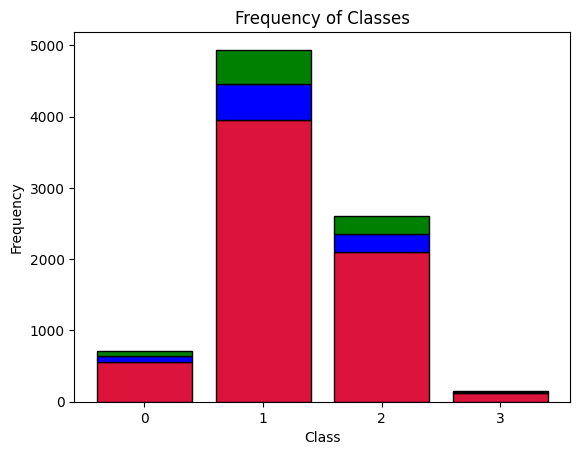

In [18]:
# Calculate the cumulative heights for the training and validation sets
cumulative_counts = np.array(class_counts_train) + np.array(class_counts_val)

plt.bar(unique_classes_train, class_counts_train, edgecolor='black', color='crimson',label='Train')
plt.bar(unique_classes_val, class_counts_val, bottom=class_counts_train, edgecolor='black', color='blue',label='Val')
plt.bar(unique_classes_test, class_counts_test, bottom=cumulative_counts, edgecolor='black', color='green',label='Test')
plt.title('Frequency of Classes')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(unique_classes)
plt.show()

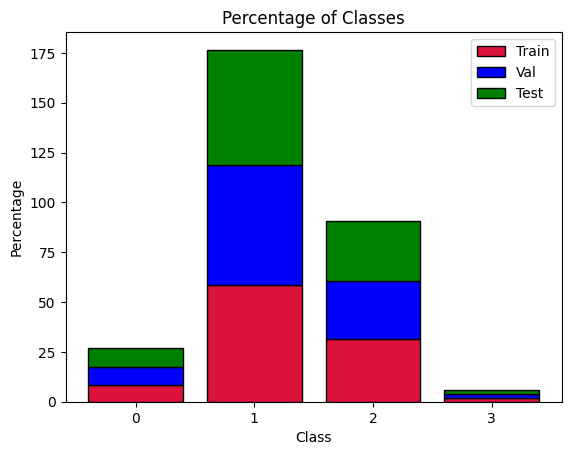

In [19]:
# Calculate the total counts for each set
total_train = np.sum(class_counts_train)
total_val = np.sum(class_counts_val)
total_test = np.sum(class_counts_test)

# Normalize the counts to percentages
percent_train = (class_counts_train / total_train) * 100
percent_val = (class_counts_val / total_val) * 100
percent_test = (class_counts_test / total_test) * 100

# Create the initial bar for the training set
plt.bar(unique_classes_train, percent_train, edgecolor='black', color='crimson', label='Train')

# Add the validation set on top of the training set
plt.bar(unique_classes_val, percent_val, bottom=percent_train, edgecolor='black', color='blue', label='Val')

# Calculate the cumulative percentages for the training and validation sets
cumulative_percent = percent_train + percent_val

# Add the test set on top of the training and validation sets
plt.bar(unique_classes_test, percent_test, bottom=cumulative_percent, edgecolor='black', color='green', label='Test')

# Add labels and title
plt.title('Percentage of Classes')
plt.xlabel('Class')
plt.ylabel('Percentage')
plt.xticks(unique_classes)
plt.legend()
plt.show()

Train percentages: [ 8.36925821 58.64426936 31.24721272  1.7392597 ]
Val percentages: [ 8.91795482 60.04756243 29.13198573  1.90249703]
Test percentages: [ 9.51248514 57.90725327 30.43995244  2.14030916]


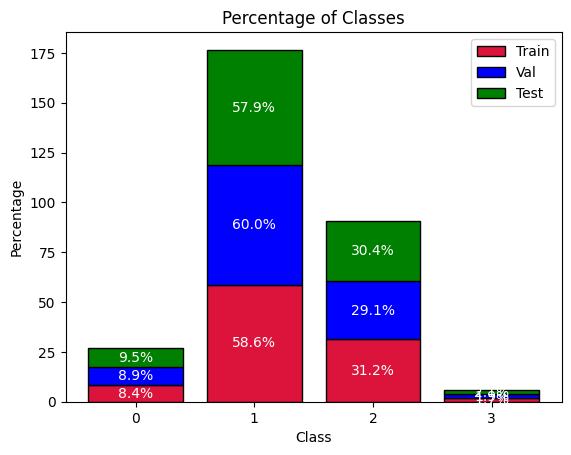

In [20]:
# Calculate the total counts for each set
total_train = np.sum(class_counts_train)
total_val = np.sum(class_counts_val)
total_test = np.sum(class_counts_test)

# Normalize the counts to percentages
percent_train = (class_counts_train / total_train) * 100
percent_val = (class_counts_val / total_val) * 100
percent_test = (class_counts_test / total_test) * 100

# Create the initial bar for the training set
bars_train = plt.bar(unique_classes_train, percent_train, edgecolor='black', color='crimson', label='Train')

# Add the validation set on top of the training set
bars_val = plt.bar(unique_classes_val, percent_val, bottom=percent_train, edgecolor='black', color='blue', label='Val')

# Calculate the cumulative percentages for the training and validation sets
cumulative_percent = percent_train + percent_val

# Add the test set on top of the training and validation sets
bars_test = plt.bar(unique_classes_test, percent_test, bottom=cumulative_percent, edgecolor='black', color='green', label='Test')

# Add text labels to the bars
for bar in bars_train:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height / 2.0, f'{height:.1f}%', ha='center', va='center', color='white')

for bar, bottom in zip(bars_val, percent_train):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, bottom + height / 2.0, f'{height:.1f}%', ha='center', va='center', color='white')

for bar, bottom in zip(bars_test, cumulative_percent):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, bottom + height / 2.0, f'{height:.1f}%', ha='center', va='center', color='white')

# Print the percentages
print("Train percentages:", percent_train)
print("Val percentages:", percent_val)
print("Test percentages:", percent_test)

# Add labels and title
plt.title('Percentage of Classes')
plt.xlabel('Class')
plt.ylabel('Percentage')
plt.xticks(unique_classes)
plt.legend()
plt.show()

In [22]:
from sklearn.model_selection import train_test_split

def split_data(X, y, train_size, val_size, test_size, random_state=None):
    """
    Splits data into train, validation, and test sets based on given sizes.

    Parameters:
    X (array-like): Features dataset.
    y (array-like): Labels dataset.
    train_size (float): Proportion of the dataset to include in the train split.
    val_size (float): Proportion of the dataset to include in the validation split.
    test_size (float): Proportion of the dataset to include in the test split.
    random_state (int, optional): Random seed for reproducibility.

    Returns:
    X_train, X_val, X_test, y_train, y_val, y_test: Split datasets.
    """
    # Check if the sum of the provided sizes is 1.0
    if train_size + val_size + test_size != 1.0:
        raise ValueError("The sum of train_size, val_size, and test_size must be 1.0")

    # First split to separate out the test set
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(val_size + test_size), random_state=random_state)
    
    # Calculate the proportion of validation set in the remaining data
    val_proportion_of_remaining = val_size / (val_size + test_size)
    
    # Split the remaining data into validation and test sets
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(1 - val_proportion_of_remaining), random_state=random_state)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [26]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(segmented_X, segmented_y, 
                                                            train_size=0.8, 
                                                            val_size=0.1, 
                                                            test_size=0.1, 
                                                            random_state=42)

In [27]:
# Train split
unique_classes_train, class_counts_train = np.unique(y_train, return_counts=True)
unique_classes_val, class_counts_val = np.unique(y_val, return_counts=True)
unique_classes_test, class_counts_test = np.unique(y_test, return_counts=True)

# PER NICOLE QUESTO è IL GRAFICO CHE INTENDEVO

Train percentages per class: [78.41225627 79.90682601 80.75297733 77.48344371]
Val percentages per class: [10.44568245 10.22888394  9.41221667 10.59602649]
Test percentages per class: [11.14206128  9.86429005  9.83480599 11.9205298 ]


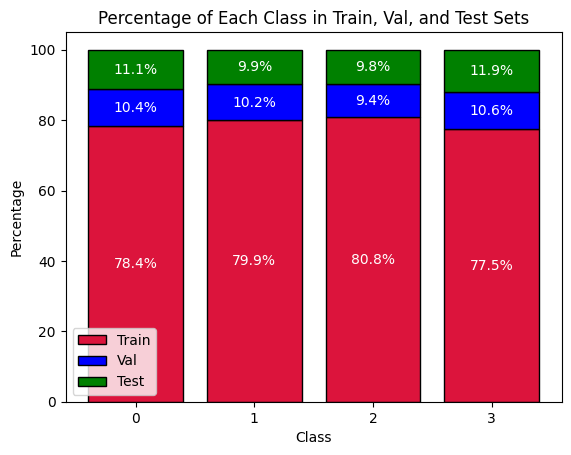

In [28]:
# Calculate the total counts for each class across all sets
total_counts_per_class = class_counts_train + class_counts_val + class_counts_test

# Normalize the counts to percentages for each class
percent_train = (class_counts_train / total_counts_per_class) * 100
percent_val = (class_counts_val / total_counts_per_class) * 100
percent_test = (class_counts_test / total_counts_per_class) * 100

# Create the initial bar for the training set
bars_train = plt.bar(unique_classes, percent_train, edgecolor='black', color='crimson', label='Train')

# Add the validation set on top of the training set
bars_val = plt.bar(unique_classes, percent_val, bottom=percent_train, edgecolor='black', color='blue', label='Val')

# Calculate the cumulative percentages for the training and validation sets
cumulative_percent = percent_train + percent_val

# Add the test set on top of the training and validation sets
bars_test = plt.bar(unique_classes, percent_test, bottom=cumulative_percent, edgecolor='black', color='green', label='Test')

# Add text labels to the bars
for bar in bars_train:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height / 2.0, f'{height:.1f}%', ha='center', va='center', color='white')

for bar, bottom in zip(bars_val, percent_train):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, bottom + height / 2.0, f'{height:.1f}%', ha='center', va='center', color='white')

for bar, bottom in zip(bars_test, cumulative_percent):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, bottom + height / 2.0, f'{height:.1f}%', ha='center', va='center', color='white')

# Print the percentages
print("Train percentages per class:", percent_train)
print("Val percentages per class:", percent_val)
print("Test percentages per class:", percent_test)

# Add labels and title
plt.title('Percentage of Each Class in Train, Val, and Test Sets')
plt.xlabel('Class')
plt.ylabel('Percentage')
plt.xticks(unique_classes)
plt.legend()
plt.show()